In [1]:
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
from pandas.tseries.holiday import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# Importing the training set
stock = 'Apple'
symbol = 'AAPL'
forecast = 5
start_date = datetime.today()+timedelta(days=-2000)
end_date = datetime.today()
training_set = web.DataReader(symbol, 'yahoo', start_date, end_date)
print training_set.shape


(1380, 6)


In [3]:
# Average of the Open, High and Low Prices is the input to our RNN.
# We also convert the Vector form of a single column into a two column matrix-form
training_set = training_set.iloc[:,1:4].values.mean(axis=1)
training_set = np.reshape(training_set, (-1, 1))

# To use Normalisation for the feature Scaling function.
# Default range for MinMaxScaler is 0 to 1, which is what we want. So no arguments in it.
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
print training_set

# Getting the inputs and the ouputs
# Restricting the input and output based on how LSTM functions.
X_train = training_set[0:training_set.shape[0]-2*forecast]
y_train = training_set[2*forecast:training_set.shape[0]]

# Reshaping - Adding time interval as a dimension for input.
X_train = np.reshape(X_train, (training_set.shape[0]-2*forecast, 1, 1))


[[ 0.13977545]
 [ 0.13272116]
 [ 0.13606629]
 ..., 
 [ 0.94047706]
 [ 0.94057414]
 [ 0.93984617]]


In [4]:

# Initialising the RNN
model = Sequential()

# Adding the input layer and the LSTM layer
# 4 memory units, tanh activation function and (None time interval with 1 attribute as input)
model.add(LSTM(units = 4, activation = 'tanh', input_shape = (None, 1)))

# Adding the output layer
# 1 nueron in the output layer for 1 dimensional output
model.add(Dense(units = 1))

# Compiling the three layers together.
# Loss helps in manipulation of weights in NN. 
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, batch_size = 128, epochs = 100)


model = load_model('5DayModel.h5')


Epoch 1/100
1370/1370 [==============================] - 0s 142us/step - loss: 0.1649
Epoch 2/100
1370/1370 [==============================] - 0s 21us/step - loss: 0.1472
Epoch 3/100
1370/1370 [==============================] - 0s 18us/step - loss: 0.1339
Epoch 4/100
1370/1370 [==============================] - 0s 22us/step - loss: 0.1219
Epoch 5/100
1370/1370 [==============================] - 0s 19us/step - loss: 0.1107
Epoch 6/100
1370/1370 [==============================] - 0s 18us/step - loss: 0.1003
Epoch 7/100
1370/1370 [==============================] - 0s 19us/step - loss: 0.0906
Epoch 8/100
1370/1370 [==============================] - 0s 18us/step - loss: 0.0816
Epoch 9/100
1370/1370 [==============================] - 0s 22us/step - loss: 0.0733
Epoch 10/100
1370/1370 [==============================] - 0s 20us/step - loss: 0.0658
Epoch 11/100
1370/1370 [==============================] - 0s 19us/step - loss: 0.0590
Epoch 12/100
1370/1370 [==============================] - 0s 2

1370/1370 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 97/100
1370/1370 [==============================] - 0s 18us/step - loss: 0.0015
Epoch 98/100
1370/1370 [==============================] - 0s 18us/step - loss: 0.0015
Epoch 99/100
1370/1370 [==============================] - 0s 18us/step - loss: 0.0015
Epoch 100/100
1370/1370 [==============================] - 0s 20us/step - loss: 0.0015


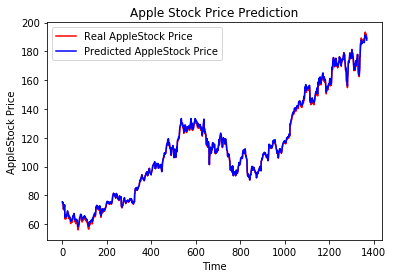

In [5]:
#Prediction and visualising results

#Prediction for the training set
real_stock_price_train = sc.inverse_transform(training_set[0:training_set.shape[0]-2*forecast])

predicted_stock_price_train = model.predict(X_train)
predicted_stock_price_train = sc.inverse_transform(predicted_stock_price_train)

plt.plot(real_stock_price_train, color = 'red', label = 'Real ' + stock + 'Stock Price')
plt.plot(predicted_stock_price_train, color = 'blue', label = 'Predicted ' + stock + 'Stock Price')
plt.title(stock +' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + 'Stock Price')
plt.legend()
plt.show()


In [6]:
train_rmse = math.sqrt(mean_squared_error(real_stock_price_train, predicted_stock_price_train))
print 'Training RMSE: ', train_rmse


Training RMSE:  0.771530675786


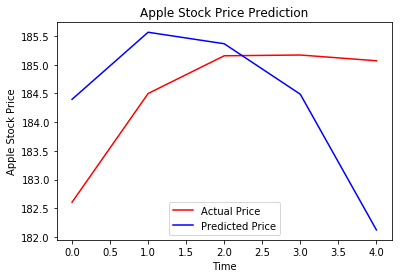

In [7]:
# Prediction on test set
test_set = web.DataReader(symbol, 'yahoo', datetime.today()+timedelta(days=-7), datetime.today())
real_stock_price_test = test_set.iloc[:,1:4].values.mean(axis=1)
real_stock_price_test = np.reshape(real_stock_price_test, (-1, 1))
test_set = web.DataReader(symbol, 'yahoo', datetime.today()+timedelta(days=-12), datetime.today()+timedelta(days=-6))
real_stock_price = test_set.iloc[:,1:4].values.mean(axis=1)
real_stock_price = np.reshape(real_stock_price, (-1, 1))
inputs = real_stock_price
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (real_stock_price.shape[0], 1, 1))
predicted_stock_price_test = model.predict(inputs)
predicted_stock_price_test = sc.inverse_transform(predicted_stock_price_test)

# Visualising the results
plt.plot(real_stock_price_test, color = 'red', label = 'Actual Price')
plt.plot(predicted_stock_price_test, color = 'blue', label = 'Predicted Price')
plt.title(stock +' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + ' Stock Price')
plt.legend()
plt.show()


In [8]:
test_rmse = math.sqrt(mean_squared_error(real_stock_price_test, predicted_stock_price_test))
print 'Test RMSE: ', test_rmse


Test RMSE:  1.64517030931


In [9]:
model.save('5DayModel.h5')